**This notebook is where we did all of our processing and exploration of the data to produce the results and figures shown in our report. It also contains initial ideas that never made it to the final report. For convience we seperated these into their own section at the end.**

---
# Initial ideas to get us started 

### Timeline 

Source: https://spice-spotlight.scot/2021/03/05/timeline-of-coronavirus-covid-19-in-scotland/
* 31 December 2019 - Chinese authorities alert WHO
* 23rd March - people only allowed to go outside to buy food, exercise once a day, or go to work if can't from home
* 24th March - First day of lockdown 
* 29th May - Move to phase 1
* 11th May - people can go outside more than once a day to exercise (household only)
* 19th June - phase 2
* 29th June - Highstreet retail open, safe return Uni announced
* 29th June <-> 13th July - Free bikes for first 30 mins
* 3rd July - 5 mile rule travel distance relaxed 
* 6th July - Outdoor hospitality opens 
* 8 July - can meet with two different households up to 8 people 
* 10 July - move to phase 3 (in doors up to 8 people, overnight allowed) 
* 13 July - dentists, shopping centers allowed to open
* 15 July - pubs, resteraunts, holiday accomadtion allowed to open 
* 16 July - no physical distancing allowed between primary and secondary school 
* 20 July - oxford show paper that vaccine working (confidence in public increases?)
* 11 August - Schools reopen
* 20 August - Scotlant remains in Stage 3
* 27 August - Police granted power to stop household parties 
* 10 Septemeber - limiiting indoor and outdoor gatherings to 6 people 
* 21 September - University of Edinburgh starts
* 22 Sep - national curfew for pubs and restaurants 
* 7 October - hospitality restriced to 6am to 6pm no sale alcohol indoors, premises may open outdoors until 10pm, with sales of alcohol. All licensed premises in the central belt area will be required to close, with the exception of takeaway services. Outdoor live events, adult contact sports and indoor group exercise classes (18+) are to be paused
* 9 November - '90% protection' vaccine announced 
* 17 November - Edinburgh remains level 3
* 8 december - Plans to start vaccinations 
* 30 December - Scottish Government urge the public to stay home during Hogmanay to suppress COVID-19.
* 5 January - Scottish Government announce mainland Scotland is to go into lockdown from 5 January 2021 with a new legal requirement forbidding anyone from leaving their home except for essential purposes. Suspension of all travel corridors
* 16 January - Lockdown restrictions strengthened
* 5 Feburary - mandatory hotel quarantine announced for 15 Feb when traveling from banned countries 
* 2 march - announcement for primary school children to return to school

### Key things to look for
* We can assume dates before 2020 are valid as a comparison for pre-COVID days. 
* Is there a sudden drop in activity at the initial lockdown?
* What about transition phase; did people begin to get cautious with all the talk before official lockdown?
* Is there a clear point where public confidence grows and they stop caring about the restrictions?
* We'd expect biking activity to increase mid July due to a lot of lifted restrictions, does data reflect this? 
* What is night time activity on bikes like before and after the early closing of restaurants and pubs?
* Does bike activity increase when people are allowed to go and exercise?
* People are forbidden to leave hom from 5th January -- does data reflect this? 

---
# Downloading and constructing initial datasets

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
mpl.rcParams['font.size'] = 9 

In [2]:
if False:
    # download the datasets
    URL = 'https://data.urbansharing.com/edinburghcyclehire.com/trips/v1/{}/{:02d}.json'
    months_2019 = [pd.read_json(URL.format('2019', month)) for month in range(1, 13)]
    months_2020 = [pd.read_json(URL.format('2020', month)) for month in range(1, 13)]
    months_2021 = [pd.read_json(URL.format('2021', month)) for month in range(1, 4)] # up to March
    pd.concat(months_2019, ignore_index=True).to_pickle('datasets/trips_2019.pkl')
    pd.concat(months_2020, ignore_index=True).to_pickle('datasets/trips_2020.pkl')
    pd.concat(months_2021, ignore_index=True).to_pickle('datasets/trips_2021.pkl')
    
trips_2019 = pd.read_pickle('datasets/trips_2019.pkl')
trips_2020 = pd.read_pickle('datasets/trips_2020.pkl')
trips_2021 = pd.read_pickle('datasets/trips_2021.pkl')
all_trips = pd.concat([trips_2019, trips_2020, trips_2021], ignore_index=True)

In [3]:
# check for any missing values
print(trips_2019.isnull().values.any())
print(trips_2020.isnull().values.any())
print(len(trips_2020[trips_2020.isnull().values]))
descriptions = trips_2020[['start_station_description', 'end_station_description']]
print(len(descriptions[descriptions.isnull().values]))
# confirmation that all null values were contained in only the start and end descriptions

False
True
5438
5438


In [4]:
# Creating 12 month long pre and post pandemic datasets. Lockdown started on 24th March. 
# pre_covid will contain trips from 25th March 2019 to 24th March 2020
# post_coivd will contain trips from 25th March 2020 to 24th March 2021 *TODO, refresh when it gets to that time*

timeline = {
    'pre_covid_start' : pd.to_datetime('2019-03-25'),
    'pre_covid_end'   : pd.to_datetime('2020-03-24'),
    'post_covid_start': pd.to_datetime('2020-03-25'),
    'post_covid_end'  : pd.to_datetime('2021-03-24')
}

pre_covid_time = ((all_trips.started_at.dt.date >= timeline['pre_covid_start']) 
                 & (all_trips.started_at.dt.date <= timeline['pre_covid_end']))
post_covid_time = ((all_trips.started_at.dt.date >= timeline['post_covid_start'])
                  & (all_trips.started_at.dt.date <= timeline['post_covid_end']))

pre_covid = all_trips[pre_covid_time]
post_covid = all_trips[post_covid_time]

In [5]:
# get number of trips in each dataset 
print('Number of trips in datasets')
print('2019:', len(trips_2019))
print('2020:', len(trips_2020))
print('2021:', len(trips_2021))
print('Pre-lockdown:', len(pre_covid))
print('Post-lockdown:', len(post_covid))

Number of trips in datasets
2019: 121110
2020: 226547
2021: 14792
Pre-lockdown: 137049
Post-lockdown: 211620


---
# Viewing parts of raw data to get some ideas into what's happening before looking ot answer our main question

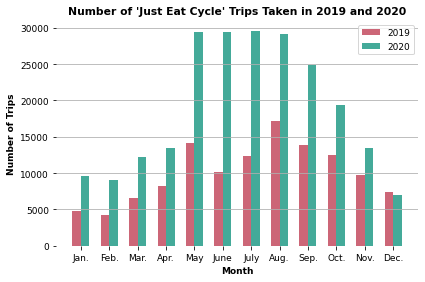

In [6]:
# https://personal.sron.nl/~pault/ - For our colourblind frienldy colours.
# number of trips 
x = np.arange(12)
width = 0.3
months = range(1, 13)
month_abbreviations = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
figure1, ax1 = plt.subplots(1, 1, figsize=(6,4))
ax1.bar(x - width/2, [len(trips_2019[trips_2019.started_at.dt.month == x]) for x in months],
       width=width, label='2019', color = '#cc6677')
ax1.bar(x + width/2, [len(trips_2020[trips_2020.started_at.dt.month == x]) for x in months],
       width=width, label='2020', color = '#44aa99')
ax1.set_xticks(x)
ax1.set_xticklabels(month_abbreviations)
ax1.set_title("Number of 'Just Eat Cycle' Trips Taken in 2019 and 2020",fontweight='bold')
ax1.set_ylabel("Number of Trips",fontweight='bold')
ax1.set_xlabel("Month",fontweight='bold')
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(axis='y')
ax1.spines["bottom"].set_visible(False)
figure1.tight_layout()
ax1.legend()
plt.savefig('number_trips.pdf')
plt.show()


# On the 11th of may people are allowed to go outside to exercise and we see an almost double increase in bike usage
# Lifted restrictions happened mid July, but people were just as active before that. 
# Since number of trips are already higher than the previous year at start of 2020, we may need to take into account
# that the bikes may naturally have been getting more popular. 
# last year there was a dip in summer months when people normally go abroad for vacation. With lockdown, it stays 
# completely flat, indicating that everyone is still there in Edinburgh

In [7]:
# what were the most popular locations pre and post covid? 
print('2019:')
print(trips_2019['start_station_name'].value_counts())
print('\n2020:')
print(print(trips_2020['start_station_name'].value_counts()))
# Honestly don't know places in Edinburgh well enough to spot anything interesting here
# But if Portobello is a beach, I think that says a lot
# the places are definetely a lot more picturesque
# for final project we need to map lat and long to indicate how many start locations were done where

2019:
Bristo Square                                          6393
St Andrew Square                                       5283
Meadows East                                           5039
Castle Street                                          3823
Portobello                                             3421
                                                       ... 
Fort Kinnaird                                             3
Depot Virtual                                             3
Pleasance - Edinburgh University Sports Fair              2
Royal Highland Show - West Gate (19th to 23rd June)       1
Cycling Scotland Conference                               1
Name: start_station_name, Length: 138, dtype: int64

2020:
Portobello - Kings Road                                    8224
Meadows East                                               7955
Meadow Place                                               6608
Duke Street                                                5864
Victoria Quay      

In [8]:
# compare bike rides from certain location 
location = 'Pollock Halls'
print('full 2019:', trips_2019['start_station_name'].value_counts()[location])
print('full 2020:', trips_2020['start_station_name'].value_counts()[location])
# what about first semester vs second semester? 
sem1_2020 = trips_2020[trips_2020.started_at.dt.month < 5] # Semester 2 First Year
sem2_2020 = trips_2020[trips_2020.started_at.dt.month > 8] 
print('sem 1 2020:', sem1_2020['start_station_name'].value_counts()[location])
print('sem 2 2020:', sem2_2020['start_station_name'].value_counts()[location])

full 2019: 2820
full 2020: 3363
sem 1 2020: 965
sem 2 2020: 1298


---
# Conducting A/B test using bootstrap simulation to compare difference between a trip in pre/post lockdown being 'long'

Probability of long trip - pre covid: 0.23704660376945472 post covid: 0.43857858425479634
probability diifference of long trip (pre - post): 0.20153198048534163
average trips per month: 13424.037037037036


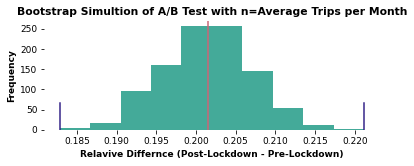

In [9]:
# so we can basically create an experiment to see for each time period: do they go for a 'long trip'?
# both periods contains at least 130K 'runs of the experiment' so we can assume our observed results 
# reflect the limiting relative frequency. 
durations_pre = pre_covid['duration'] / 60
durations_post = post_covid['duration'] / 60

long_trip = 30 # minutes

results_pre = (durations_pre > long_trip).to_numpy()
results_post = (durations_post > long_trip).to_numpy()

# probabilities of there being a long trip in each time period
p_long_pre = sum(results_pre) / len(results_pre)
p_long_post = sum(results_post) / len(results_post)
print(f'Probability of long trip - pre covid: {p_long_pre} post covid: {p_long_post}')
actual_diff = p_long_post - p_long_pre
print(f'probability diifference of long trip (pre - post): {actual_diff}')

# now that we have our objective probabilites of a long trip in each time period and a long trip is a
# binomial variable (it can either be a long trip or not, so probability of not a long trip is (1-p)),
# we can use that to work out the probability for the number of long trips in a certain amount of trips
# using a binomial distribution -- by finding the number of combinations for those trips time its 
# probability using our relative frequencies. We can then sample a number of long trips according to each 
# distribution and compare the difference. If we do this over and over we will then be left with a distribution 
# of how many times there were more long trips in pre compared to post and by how much. 

trips_per_month = []
for trips in [trips_2019, trips_2020, trips_2021]:
    for m in range(1, 13):
        if id(trips) == id(trips_2021) and m == 4: break
        trips_per_month.append(sum(trips.started_at.dt.month == m))
        
average_trips_month = sum(trips_per_month) / len(trips_per_month)
print('average trips per month:', average_trips_month)

# using bootstrapping
runs = 1000 # how many times to sample from each distribution
n = average_trips_month  # how many trips we consider in our binomial distributions 
           # here I'm using average number of trips per month
differences = []
for i in range(runs):
    n_long_pre = np.random.binomial(n=n, p=p_long_pre)
    n_long_post = np.random.binomial(n=n, p=p_long_post)
    differences.append((n_long_post - n_long_pre) / n)
figure2, ax1 = plt.subplots(1, 1, figsize=(6,2))
ax1.set_title("Bootstrap Simultion of A/B Test with n=Average Trips per Month",fontweight='bold')
ax1.set_ylabel("Frequency",fontweight='bold')
ax1.set_xlabel("Relavive Differnce (Post-Lockdown - Pre-Lockdown)",fontweight='bold')
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
figure1.tight_layout() 
ax1.hist(differences, color='#44aa99')
ax1.axvline(actual_diff,color='#cc6677')
ax1.axvline(min(differences),ymin=0,ymax=0.25,color='#332288')
ax1.axvline(max(differences),ymin=0,ymax=0.25,color='#332288')
plt.savefig('bootstrap.pdf')
plt.show()            

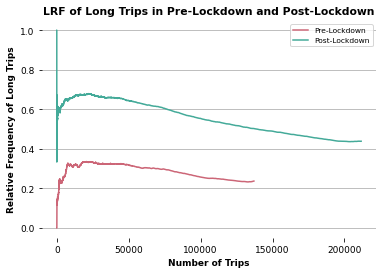

In [10]:
# we can calculate and look at our relative frequencies as n tends to infinity
relative_frequencies_pre = []
successes = 0
for i in range(len(results_pre)):
    successes += results_pre[i]
    relative_frequencies_pre.append(successes / (i+1))

relative_frequencies_post = []
successes = 0
for i in range(len(results_post)):
    successes += results_post[i]
    relative_frequencies_post.append(successes / (i+1))
figure3, ax1 = plt.subplots(1, 1, figsize=(6,4))
prelockdown, = ax1.plot(relative_frequencies_pre, color = '#cc6677')
postlockdown, = ax1.plot(relative_frequencies_post, color = '#44aa99')
ax1.set_title("LRF of Long Trips in Pre-Lockdown and Post-Lockdown",fontweight='bold')
ax1.set_ylabel("Relative Frequency of Long Trips",fontweight='bold')
ax1.set_xlabel("Number of Trips",fontweight='bold')
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(axis='y')
ax1.spines["bottom"].set_visible(False)
figure1.tight_layout()
handles,labels = ax1.get_legend_handles_labels()
ax1.legend((prelockdown, postlockdown), ("Pre-Lockdown", "Post-Lockdown"), fontsize="small")
plt.savefig('relative_frequency.pdf')
plt.show()


---
# Viewing activity of stations on map of Edinburgh (plus initial heavy processing)

In [11]:
# ------ PROCESSING ------
# Need to determine if a station got replaced in December and if it did what to. 
# For fair comparison we can combine all station locations in 2019 set that don't
# exist in the 2020 set to the closest location that does. (In most cases this will
# be the exact same location that has just been updated, but even if its not it 
# still makes sense to do this for fair comparison). 

pre_covid = pre_covid[pre_covid.end_station_latitude > 55] # first removing the 3 trips that end in Liverpool

def get_unique_coordinates(trips):
    starts = set(zip(trips.start_station_latitude, trips.start_station_longitude))
    ends = set(zip(trips.end_station_latitude, trips.end_station_longitude))
    unique = starts | ends
    return list(unique)
    
coordinates_2019 = get_unique_coordinates(pre_covid)
coordinates_2020 = get_unique_coordinates(post_covid)

columns = ['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']
pre_covid_replaced = pre_covid[columns]

def find_closest_coordinate(coordinate, valid_coordinates):
    
    def distance(x, y):
        return (x[0] - y[0])**2 + (x[1] - y[1])**2
    
    min_distance = float('inf')
    min_coordinate = None
    for valid_coordinate in valid_coordinates:
        dist = distance(coordinate, valid_coordinate)
        if dist < min_distance:
            min_distance = dist
            min_coordinate = valid_coordinate
    return min_coordinate

for coordinate in coordinates_2019:
    if coordinate not in coordinates_2020:
        closest = find_closest_coordinate(coordinate, coordinates_2020)
        old_start = {'start_station_latitude': coordinate[0], 'start_station_longitude': coordinate[1]}
        new_start = {'start_station_latitude': closest[0], 'start_station_longitude': closest[1]}
        old_end = {'end_station_latitude': coordinate[0], 'end_station_longitude': coordinate[1]}
        new_end = {'end_station_latitude': closest[0], 'end_station_longitude': closest[1]}
        pre_covid_replaced = pre_covid_replaced.replace(old_start, new_start)
        pre_covid_replaced = pre_covid_replaced.replace(old_end, new_end)

pre_covid_replaced.head()

start_station_latitude  start_station_longitude  end_station_latitude  \
13780               55.950109                -3.190258             55.960852   
13781               55.940238                -3.194640             55.939809   
13782               55.952641                -3.187527             55.944859   
13783               55.954906                -3.192444             55.962804   
13784               55.944859                -3.182590             55.940081   

       end_station_longitude  
13780              -3.180986  
13781              -3.182739  
13782              -3.182590  
13783              -3.196284  
13784              -3.171747

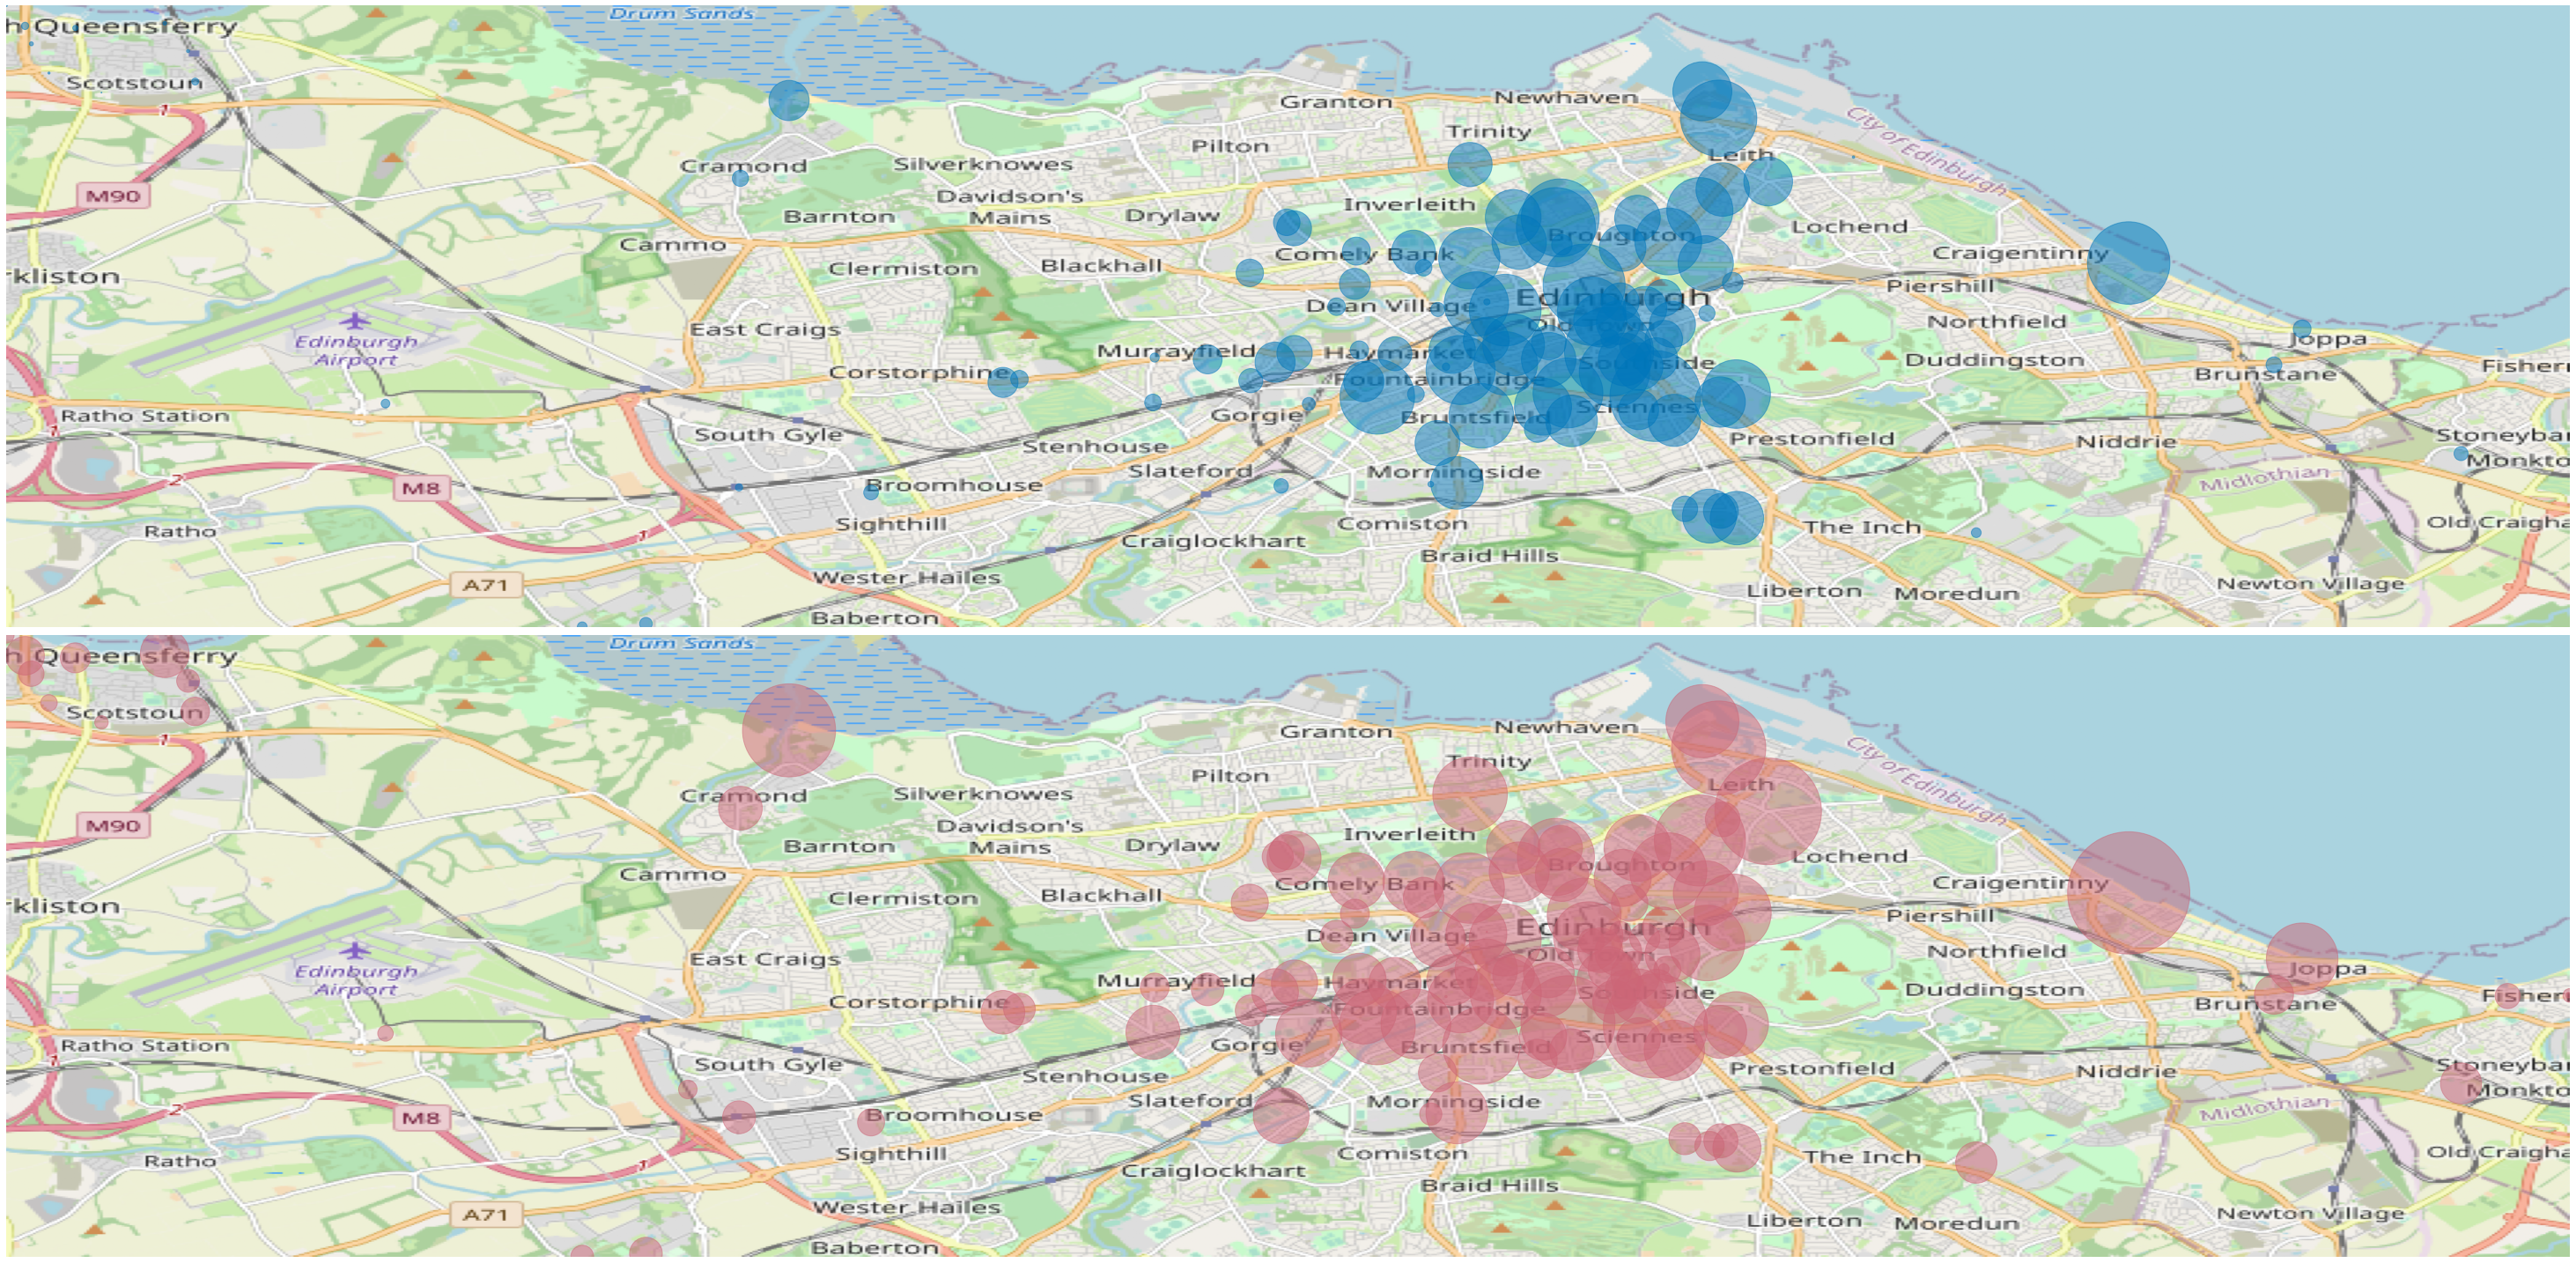

In [12]:
# Heat map -- want to create a map of Edinburgh where we plot all bike locations with a dot representative of how
# many trips were made there each year

def get_location_info(trips, pos):
    locs = trips[[f'{pos}_station_latitude', f'{pos}_station_longitude']]
    locs = locs.value_counts().to_frame().reset_index()
    locs.columns = ['latitude', 'longitude', 'counts']
    return locs

starts_pre = get_location_info(pre_covid_replaced, 'start')
ends_pre   = get_location_info(pre_covid_replaced, 'end')
starts_post = get_location_info(post_covid, 'start')
ends_post   = get_location_info(post_covid, 'end')

# recievie min and max lat and long for determining size of map we need
map_size = {'min_long': float('inf'), 'max_long': float('-inf'), 'min_lat': float('inf'), 'max_lat': float('-inf')}

for df in [starts_pre, ends_pre, starts_post, ends_post]:
    if df.latitude.min() < map_size['min_lat']:
        map_size['min_lat'] = df.latitude.min()
    if df.longitude.min() < map_size['min_long']:
        map_size['min_long'] = df.longitude.min()
    if df.latitude.max() > map_size['max_lat']:
        map_size['max_lat'] = df.latitude.max()
    if df.longitude.max() > map_size['max_long']:
        map_size['max_long'] = df.longitude.max()
        
# at this point I entered the min/max lat/long coordinates into opestreetmap.org and downloaded map as 'map.png'

edinburgh_map = plt.imread('map.png') # with boundaries according to map_size

# --- adjusting to combine starts and ends instead 
pre_activity = pd.merge(starts_pre, ends_pre, how='outer', on=['latitude', 'longitude'])
pre_activity.columns = ['latitude', 'longitude', 'counts_s', 'counts_e']
pre_activity = pre_activity.fillna(0)
pre_activity['counts'] = pre_activity.apply(lambda x : x.counts_s + x.counts_e, axis=1)

post_activity = pd.merge(starts_post, ends_post, how='outer', on=['latitude', 'longitude'])
post_activity.columns = ['latitude', 'longitude', 'counts_s', 'counts_e']
post_activity = post_activity.fillna(0)
post_activity['counts'] = post_activity.apply(lambda x : x.counts_s + x.counts_e, axis=1)

fig, axs = plt.subplots(2, 1, figsize=(60, 20))
alpha = 0.5
title_size = 20

for i in range(2):
    axs[i].set_xlim(map_size['min_long'], map_size['max_long'])
    axs[i].set_ylim(map_size['min_lat'], map_size['max_lat'])
    axs[i].imshow(edinburgh_map, zorder=0, extent=map_size.values(), aspect='equal')

axs[0].scatter(pre_activity.longitude, pre_activity.latitude, s=pre_activity.counts, alpha=alpha, c='#0077bb')

axs[1].scatter(post_activity.longitude, post_activity.latitude, s=post_activity.counts, alpha=alpha, c='#cc6677')

axs[1].axis("off")
axs[0].axis('off')
fig.tight_layout() 

extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('pre-lockdown_map.png', bbox_inches=extent)
extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('post-lockdown_map.png', bbox_inches=extent)
plt.show()

---
# Constructing table for stations and their pre, post and change in activity

In [13]:
starts = pd.merge(starts_pre, starts_post, on=['latitude', 'longitude'])
ends = pd.merge(ends_pre, ends_post, on=['latitude', 'longitude'])
starts.columns = ['latitude', 'longitude', 'counts_pre', 'counts_post']
ends.columns = ['latitude', 'longitude', 'counts_pre', 'counts_post']

# getting activity counts 
trip_activity = pd.merge(starts, ends, on=['latitude', 'longitude'])
trip_activity.columns = ['latitude', 'longitude', 'counts_pre_s', 'counts_post_s', 'counts_pre_e', 'counts_post_e']
trip_activity['activity_pre'] = trip_activity.apply(lambda row : row.counts_pre_s + row.counts_pre_e, axis=1)
trip_activity['activity_post'] = trip_activity.apply(lambda row : row.counts_post_s + row.counts_post_e, axis=1)
trip_activity = trip_activity.drop(['counts_pre_s', 'counts_post_s', 'counts_pre_e', 'counts_post_e'], axis=1)
trip_activity['activity_change'] = trip_activity.apply(lambda row : row.activity_post - row.activity_pre, axis=1)
trip_activity = trip_activity.sort_values('activity_change', ascending=False)
trip_activity['station_name'] = ""
   
# retrieve station name corresponding to grid coordinates
for i, row in trip_activity.iterrows():
    lat = row['latitude']
    long = row['longitude']
    mask = (post_covid.start_station_latitude == lat) & (post_covid.start_station_longitude == long)
    name = post_covid[mask].iloc[0]['start_station_name']
    trip_activity.at[i, 'station_name'] = name
    
top = trip_activity.head(3).drop(['latitude', 'longitude'], axis=1)
order = ['station_name', 'activity_pre', 'activity_post', 'activity_change']
top_formal = pd.DataFrame()
for c in order:
    top_formal[c] = top[c]
    
top_formal.columns = ['Station Name', 'Pre-Lockdown Activity', 'Post-Lockdown Activity', 'Change in Activity (Post - Pre)']
display(top_formal)
print(top_formal.to_latex(index=False))

bot = trip_activity.tail(3).drop(['latitude', 'longitude'], axis=1)
order = ['station_name', 'activity_pre', 'activity_post', 'activity_change']
bot_formal = pd.DataFrame()
for c in order:
    bot_formal[c] = bot[c]
    
bot_formal.columns = ['Station Name', 'Pre-Lockdown Activity', 'Post-Lockdown Activity', 'Change in Activity (Post - Pre)']
display(bot_formal)
print(bot_formal.to_latex(index=False))

Station Name  Pre-Lockdown Activity  Post-Lockdown Activity  \
47              Duke Street                 3080.0                 14668.0   
4   Portobello - Kings Road                 8770.0                 19263.0   
54        Cramond Foreshore                 2095.0                 11169.0   

    Change in Activity (Post - Pre)  
47                          11588.0  
4                           10493.0  
54                           9074.0

\begin{tabular}{lrrr}
\toprule
            Station Name &  Pre-Lockdown Activity &  Post-Lockdown Activity &  Change in Activity (Post - Pre) \\
\midrule
             Duke Street &                 3080.0 &                 14668.0 &                          11588.0 \\
 Portobello - Kings Road &                 8770.0 &                 19263.0 &                          10493.0 \\
       Cramond Foreshore &                 2095.0 &                 11169.0 &                           9074.0 \\
\bottomrule
\end{tabular}



Station Name  Pre-Lockdown Activity  Post-Lockdown Activity  \
0      Bristo Square                10217.0                  5337.0   
15   Waverley Bridge                 6028.0                   842.0   
13  Logie Green Road                 7829.0                  2567.0   

    Change in Activity (Post - Pre)  
0                           -4880.0  
15                          -5186.0  
13                          -5262.0

\begin{tabular}{lrrr}
\toprule
     Station Name &  Pre-Lockdown Activity &  Post-Lockdown Activity &  Change in Activity (Post - Pre) \\
\midrule
    Bristo Square &                10217.0 &                  5337.0 &                          -4880.0 \\
  Waverley Bridge &                 6028.0 &                   842.0 &                          -5186.0 \\
 Logie Green Road &                 7829.0 &                  2567.0 &                          -5262.0 \\
\bottomrule
\end{tabular}



# Observing how many trips started and ended in same location

In [14]:
# determining how many trips started and ended in same location for each time period
pre_mask = (pre_covid['start_station_id'] == pre_covid['end_station_id'])
same_pre = pre_covid[pre_mask]
print('Number of trips that started and ended in same location pre lockdown:', len(same_pre))
post_mask = (post_covid['start_station_id'] == post_covid['end_station_id'])
same_post = post_covid[post_mask]
print('Number of trips that started and ended in same location pre lockdown:', len(same_post))
n_pre_trips = len(pre_covid)
n_post_trips = len(post_covid)
print('Percentage increase in total number of trips:', (len(post_covid) - len(pre_covid)) / len(pre_covid) * 100)
print('Percentage increase in same start/end trips:', (len(same_post) - len(same_pre)) / len(same_pre) * 100)

Number of trips that started and ended in same location pre lockdown: 12450
Number of trips that started and ended in same location pre lockdown: 40024
Percentage increase in total number of trips: 54.41192566162467
Percentage increase in same start/end trips: 221.47791164658636


---
# Abondend ideas

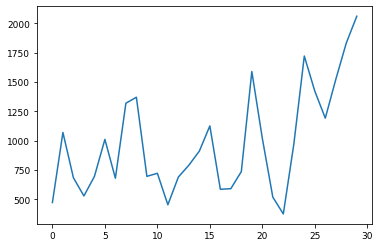

In [15]:
# does number of trips in May correspond to announcement?
may_covid = trips_2020[trips_2020.started_at.dt.month == 5]
trips_per_day = [len(may_covid[may_covid.started_at.dt.day == x]) for x in range(1, 31)]
plt.plot(trips_per_day)
# not really lol
# bike usage tends to go down on weekends, would imply people mainly use them for commute and not pleasure

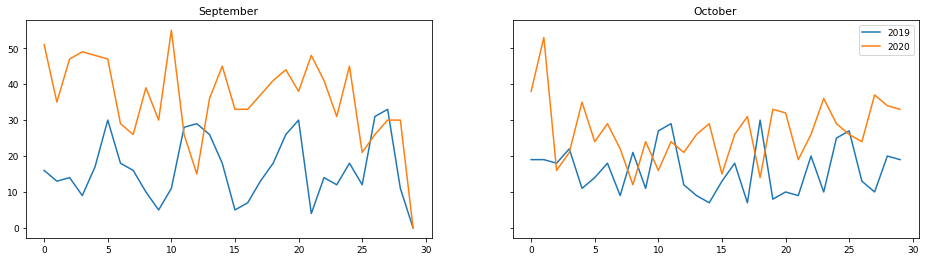

In [16]:
# what about number of post 10 pm rides before and after curfew? 
def late_night_trips(month):
    late_2019 = trips_2019[(trips_2019.started_at.dt.month == month) & (trips_2019.started_at.dt.hour >= 22)]
    late_2020 = trips_2020[(trips_2020.started_at.dt.month == month) & (trips_2020.started_at.dt.hour >= 22)]
    late_per_day_2019 = [len(late_2019[late_2019.started_at.dt.day == x]) for x in range(1, 31)]
    late_per_day_2020 = [len(late_2020[late_2020.started_at.dt.day == x]) for x in range(1, 31)] 
    return late_per_day_2019, late_per_day_2020

late_sep_2019, late_sep_2020 = late_night_trips(9)
late_oct_2019, late_oct_2020 = late_night_trips(10)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,4))
axs[0].plot(late_sep_2019, label='2019')
axs[0].plot(late_sep_2020, label='2020')
axs[0].set_title('September')
axs[1].plot(late_oct_2019, label='2019')
axs[1].plot(late_oct_2020, label='2020')
axs[1].set_title('October')
plt.legend()
# curfew happens on 22'nd of septermber so kinda yeah
# it drops down to same amount as previous year (unusual) and stays there for coulple weeks before seperating again

0.20152
2.3263478740408408
(0.1967101825846349, 0.2063298174153651)


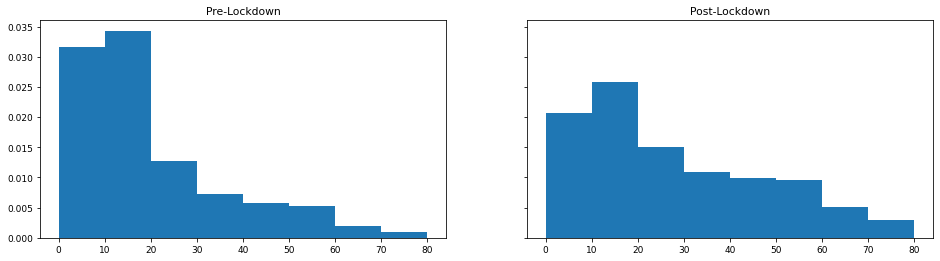

In [17]:
# Theoretical approach to A/B testing
# What is the percentage breakdown of duration of trips each year? 
trips_duration_pre = pre_covid['duration'] / 60 # now in minutes 
trips_duration_post = post_covid['duration'] / 60
# We will conduct an A/B test to see whether customers of 'Just Eat Cycles really did opt to take longer trips'
bins = range(0, 90, 10)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,4))
axs[0].hist(trips_duration_pre, density=True, bins=bins)
axs[0].set_title('Pre-Lockdown')
axs[1].hist(trips_duration_post, density=True, bins=bins)
axs[1].set_title('Post-Lockdown')
# We see that the spread of trips is different in 2020 compared to the previous year.
# We are taking a prop
#print(trips_duration_pre[trips_duration_pre>30].count())
#print(trips_duration_post[trips_duration_post>30].count())
n = 100000
sample_pre = trips_duration_pre.sample(n)
sample_post = trips_duration_post.sample(n)
proprotion_pre = sample_pre[sample_pre>30].count()/sample_pre.count()
proprotion_post = sample_post[sample_post>30].count()/sample_post.count()
#print(proprotion_pre)
#print(proprotion_post)
#print(trips_duration_post.count())
#print(trips_duration_pre.count())
difference = proprotion_post - proprotion_pre
print(difference)
standard_error_pre = np.sqrt(proprotion_pre*(1-proprotion_pre)/n)
standard_error_post = np.sqrt(proprotion_post*(1-proprotion_post)/n)
standard_deviation_difference = np.sqrt(standard_error_pre**2 + standard_error_post**2)
z_score = difference/standard_deviation_difference
from scipy import stats
alpha = 0.01
z_critical_score = stats.norm.ppf(1 - alpha)
print(z_critical_score)
confidence_interval = (difference-(z_critical_score)*standard_deviation_difference,difference+(z_critical_score)*standard_deviation_difference)
print(confidence_interval)

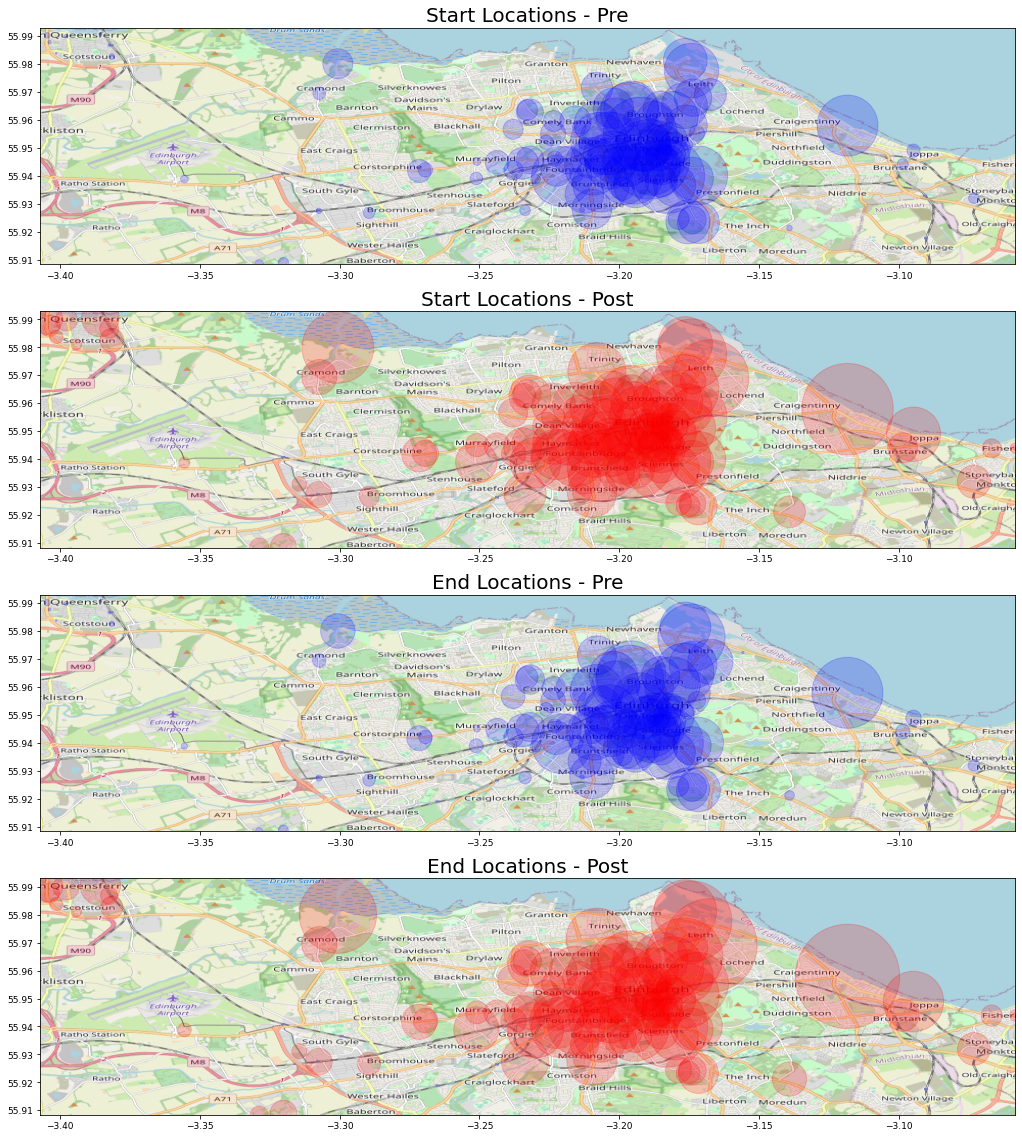

In [18]:
# Heat map -- want to create a map of Edinburgh where we plot all bike locations with a dot representative of how
# many trips were made there each year

def get_location_info(trips, pos):
    locs = trips[[f'{pos}_station_latitude', f'{pos}_station_longitude']]
    locs = locs.value_counts().to_frame().reset_index()
    locs.columns = ['latitude', 'longitude', 'counts']
    return locs

starts_2019 = get_location_info(pre_covid_replaced, 'start')
ends_2019   = get_location_info(pre_covid_replaced, 'end')
starts_2020 = get_location_info(post_covid, 'start')
ends_2020   = get_location_info(post_covid, 'end')

# recievie min and max lat and long for determining size of map we need
map_size = {'min_long': float('inf'), 'max_long': float('-inf'), 'min_lat': float('inf'), 'max_lat': float('-inf')}

for df in [starts_2019, ends_2019, starts_2020, ends_2020]:
    if df.latitude.min() < map_size['min_lat']:
        map_size['min_lat'] = df.latitude.min()
    if df.longitude.min() < map_size['min_long']:
        map_size['min_long'] = df.longitude.min()
    if df.latitude.max() > map_size['max_lat']:
        map_size['max_lat'] = df.latitude.max()
    if df.longitude.max() > map_size['max_long']:
        map_size['max_long'] = df.longitude.max()
        
# at this point I entered the min/max lat/long coordinates into opestreetmap.org and downloaded map as 'map.png'

edinburgh_map = plt.imread('map.png') # with boundaries according to map_size

fig, axs = plt.subplots(4, 1, figsize=(60, 20))
alpha = 0.2
title_size = 20

for i in range(4):
    axs[i].set_xlim(map_size['min_long'], map_size['max_long'])
    axs[i].set_ylim(map_size['min_lat'], map_size['max_lat'])
    axs[i].imshow(edinburgh_map, zorder=0, extent=map_size.values(), aspect='equal')

axs[0].scatter(starts_2019.longitude, starts_2019.latitude, s=starts_2019.counts, alpha=alpha, c='b')
axs[0].set_title('Start Locations - Pre', fontsize=title_size)

axs[1].scatter(starts_2020.longitude, starts_2020.latitude, s=starts_2020.counts, alpha=alpha, c='r')
axs[1].set_title('Start Locations - Post', fontsize=title_size)

axs[2].scatter(ends_2019.longitude, ends_2019.latitude, s=ends_2019.counts, alpha=alpha, c='b')
axs[2].set_title('End Locations - Pre', fontsize=title_size)

axs[3].scatter(ends_2020.longitude, ends_2020.latitude, s=ends_2020.counts, alpha=alpha, c='r')
axs[3].set_title('End Locations - Post', fontsize=title_size)


plt.show()

# Things we can potentially add:
# * Percentage increase in some of popular rural areas -- are these percentage increases greater than the 
#   percentage increases for locations in the city. 
# * Check whether the locations in top left existed in 2019 (I'm guessing they didn't rather than no one using them.)
#   - we could do all our comparisons based on only locations that were shared across both years. 
# * Experiment with both on same map